## Imports

In [1]:
# stdlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set_style("white")
import numpy as np
from time import time
%matplotlib inline
# project
from TP2_python.arms import ArmBernoulli, ArmBeta, ArmExp, ArmFinite
from TP2_python.linearmab_models import ToyLinearModel, ColdStartMovieLensModel

# 1. Stochastic Multi-Armed Bandits on Simulated Data

## 1.1 Bernoulli bandit models

In [2]:
# definition of bandit models
K = 5

# First Bandit problem
arm0 = ArmBernoulli(0.17, random_state=np.random.randint(1, 100000))
arm1 = ArmBernoulli(0.29, random_state=np.random.randint(1, 100000))
arm2 = ArmBernoulli(0.24, random_state=np.random.randint(1, 100000))
arm3 = ArmBernoulli(0.20, random_state=np.random.randint(1, 100000))
arm4 = ArmBernoulli(0.11, random_state=np.random.randint(1, 100000))

MAB1 = [arm0, arm1, arm2, arm3, arm4]
means1 = [el.mean for el in MAB1]

# Second Bandit problem
arm00 = ArmBernoulli(0.50, random_state=np.random.randint(1, 100000))
arm11 = ArmBernoulli(0.35, random_state=np.random.randint(1, 100000))
arm33 = ArmBernoulli(0.45, random_state=np.random.randint(1, 100000))
arm22 = ArmBernoulli(0.40, random_state=np.random.randint(1, 100000))

MAB2 = [arm00, arm11, arm22]
means2 = [el.mean for el in MAB2]

#### 1.a UCB1

In [154]:
def one_ucb1(MAB, N_t, S_t, t, gho):
    """Compute one iteration of the UCB1 algorithm.
    
    Parameters:
    -----------
    
    MAB: list (arms)
        Multi arm bandit arms
    N_t: array, shape = [n_arms,]
        Number of draws of arms up to time t
    S_t: array, shape = [n_arms,]
        Sum of rewards gathered up to time t
    t: int
        Time of the step
    gho: float
        Parameter of the algorithm
    
    Returns:
    --------
    arm: integer
        id of arm to be pulled chosen by the algorithm
    reward: float
        The reward obtained
    N_t: array, shape = [n_arms,]
        Updated N_t
    S_t: array, shape = [n_arms,]
        Updated S_t
    t: int
        Next time ;)
    """
    
    mu = S_t / N_t
    temp = gho * np.sqrt(np.log(t) / (2 * N_t))
    temp = mu + temp
    arm = np.argmax(temp)
    reward = float(MAB[arm].sample())
    N_t[arm] = N_t[arm] + 1
    S_t[arm] = S_t[arm] + reward
    t = t + 1
    return arm, reward, N_t, S_t, t

def ucb1(T, MAB, gho=1):
    """Simulate a bandit game of length T with the UCB1.
    
    Parameters:
    -----------
    T: int
        Length of the simulation
    MAB: list (arms)
        Multi arm bandit arms
    gho: float (optional)
        Parameter of the algorithm
    
    Returns:
    --------
    rew: list(float)
        Sequence of the T rewards obtained
    draws: list(int)
        Sequence of the T arms drawn
    """
    rew, draws = [], []
    K = len(MAB)
    N_t = np.zeros(K)
    S_t = np.zeros(K)
    if T <= K:
        for i in range(T):
            N_t[i] = 1
            S_t[i] = int(MAB[i].sample())
            return list(S_t), list(range(T))
    else:
        for i in range(K):
            N_t[i] = 1
            S_t[i] = int(MAB[i].sample())
        t = K + 1
        rew, draws = list(S_t), list(range(K))
        for i in range(T - K):
            arm, reward, N_t, S_t, t = one_ucb1(MAB, N_t, S_t, t, gho)
            rew.append(reward)
            draws.append(arm)
    return rew, draws

#### 1.b TS

In [5]:
def one_ts(MAB, N_t, S_t):
    """Compute one iteration of the Thompson Sampling strategy.
    
    Parameters:
    -----------
    
    MAB: list (arms)
        Multi arm bandit arms
    N_t: array, shape = [n_arms,]
        Number of draws of arms up to time t
    S_t: array, shape = [n_arms,]
        Sum of rewards gathered up to time t
    
    Returns:
    --------
    arm: integer
        id of arm to be pulled chosen by the algorithm
    reward: float
        The reward obtained
    N_t: array, shape = [n_arms,]
        Updated N_t
    S_t: array, shape = [n_arms,]
        Updated S_t
    """
    K = len(MAB)
    betas = np.array([np.random.beta(S_t[i] + 1, N_t[i] - S_t[i] + 1)  for i in range(K)])
    arm = np.argmax(betas)
    reward = float(MAB[arm].sample())
    N_t[arm] = N_t[arm] + 1
    S_t[arm] = S_t[arm] + reward
    return arm, reward, N_t, S_t

def ts(T, MAB):
    """Simulate a bandit game of length T with the Thompson Sampling strategy.
    
    Parameters:
    -----------
    T: int
        Length of the simulation
    MAB: list (arms)
        Multi arm bandit arms
    
    Returns:
    --------
    rew: list(float)
        Sequence of the T rewards obtained
    draws: list(int)
        Sequence of the T arms drawn
    """
    rew, draws = [], []
    K = len(MAB)
    N_t = np.zeros(K)
    S_t = np.zeros(K)
    if T <= K:
        for i in range(T):
            N_t[i] = 1
            S_t[i] = int(MAB[i].sample())
            return list(S_t), list(range(T))
    else:
        for i in range(K):
            N_t[i] = 1
            S_t[i] = int(MAB[i].sample())
            
        rew, draws = list(S_t), list(range(K))
        for i in range(T - K):
            arm, reward, N_t, S_t= one_ts(MAB, N_t, S_t)
            rew.append(reward)
            draws.append(arm)
    return rew, draws

#### Naive strategy

In [80]:
def one_ns(MAB, N_t, S_t):
    """Compute one iteration of the naive strategy.
    
    Parameters:
    -----------
    
    MAB: list (arms)
        Multi arm bandit arms
    N_t: array, shape = [n_arms,]
        Number of draws of arms up to time t
    S_t: array, shape = [n_arms,]
        Sum of rewards gathered up to time t
    
    Returns:
    --------
    arm: integer
        id of arm to be pulled chosen by the algorithm
    reward: float
        The reward obtained
    N_t: array, shape = [n_arms,]
        Updated N_t
    S_t: array, shape = [n_arms,]
        Updated S_t
    """
    K = len(MAB)
    scores = S_t / N_t
    arm = np.argmax(scores)
    reward = float(MAB[arm].sample())
    N_t[arm] = N_t[arm] + 1
    S_t[arm] = S_t[arm] + reward
    return arm, reward, N_t, S_t

def ns(T, MAB):
    """Simulate a bandit game of length T with the naive strategy.
    
    Parameters:
    -----------
    T: int
        Length of the simulation
    MAB: list (arms)
        Multi arm bandit arms
    
    Returns:
    --------
    rew: list(float)
        Sequence of the T rewards obtained
    draws: list(int)
        Sequence of the T arms drawn
    """
    rew, draws = [], []
    K = len(MAB)
    N_t = np.zeros(K)
    S_t = np.zeros(K)
    if T <= K:
        for i in range(T):
            N_t[i] = 1
            S_t[i] = int(MAB[i].sample())
            return list(S_t), list(range(T))
    else:
        for i in range(K):
            N_t[i] = 1
            S_t[i] = int(MAB[i].sample())
            
        rew, draws = list(S_t), list(range(K))
        for i in range(T - K):
            arm, reward, N_t, S_t= one_ns(MAB, N_t, S_t)
            rew.append(reward)
            draws.append(arm)
    return rew, draws

#### 2. Regret curve

In [200]:
def expected_regret(MAB, T, n, algos):
    """Return the expected regret of the algorithm algo
    
    Parameters:
    -----------
    MAB: list (arms)
        Multi arm bandit arms
    T: int
        Time horizon
    n: int
        Number of simulations
    algos: list (str), possible choices = [ucb1, ts, ns]
        List of choseen algorithms
        
    returns:
    --------
    regrets: array, shape=(n_algos, T)
        regret for the algos
    """
    algo = {"ucb1": ucb1, "ts": ts, "ns": ns, "adapted_ts": adapted_ts}
    means = [el.mean for el in MAB]
    max_reward = max(means)
    regrets = np.zeros((len(algos), n, T))
    for s in tqdm(range(n)):
        for i, alg in enumerate(algos):
            rew, _ = algo[alg](T, MAB)
            regrets[i, s, :] = np.array(max_reward) - rew
    regrets = regrets.mean(axis=1)
    for i in range(1, T):
        regrets[:, i] = regrets[:, i - 1] + regrets[:, i]
    return regrets

In [147]:
expected_regret(MAB1, 20, 100, ["ucb1", "ts", "ns"])

100%|██████████| 100/100 [00:00<00:00, 2404.78it/s]


array([[0.12, 0.21, 0.31, 0.42, 0.6 , 0.69, 0.77, 0.81, 0.95, 1.04, 1.09,
        1.15, 1.2 , 1.31, 1.36, 1.39, 1.45, 1.47, 1.6 , 1.67]])

#### 3. Lai and Robbins lower bound

In [8]:
def KL(x, y):
    """Compute KL for x & y"""
    t1 = x * np.log(x/y)
    t2 = (1 - x) * np.log((1 - x) / (1 - y))
    return t1 + t2

def compute_C(MAB):
    """Compute the complexity of MAB
    
    Parameters:
    -----------
    MAB: list (arms)
        Multi arm bandit arms
    
    Returns:
    --------
    C: float
        Complexity of MAB
    """
    means = [el.mean for el in MAB]
    ps = max(means)
    c = sum([(ps - p) / KL(p, ps) for p in means if p != ps])
    return c

def oracle(T, C):
    """Compute the oracle curve for T.
    
    Parameters:
    -----------
    T: int
        Value that will be used to compute oracle
    C: float
        Complexity of the MAB
    
    Returns:
    --------
    oracle: float
        Value of the oracle at T
    """
    return C * np.log(T)

In [62]:
compute_C(MAB1)
np.log(5000) * compute_C(MAB1)
#1 / KL(0.5, 0.47)

146.34514619219934

### Q1. Plots

In [155]:
T = 10000
n = 100
algos = ["ucb1", "ts", "ns"]
MAB = MAB1

In [171]:
# For MAB1
regrets = expected_regret(MAB, T, n, algos)
ucb1_regrets = regrets[0, :]
ts_regrets = regrets[1, :]
naive_regrets = regrets[2, :]
C1 = compute_C(MAB)
oracles = [oracle(i, C1) for i in range(1 , T + 1)]

100%|██████████| 100/100 [00:28<00:00,  3.51it/s]


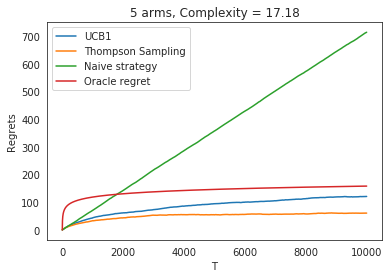

In [172]:
plt.plot(ucb1_regrets)
plt.plot(ts_regrets)
plt.plot(naive_regrets)
plt.plot(oracles)
plt.xlabel("T")
plt.ylabel("Regrets")
plt.title("5 arms, Complexity = {}".format(round(C1, 2)))
plt.legend(['UCB1', 'Thompson Sampling', 'Naive strategy', 'Oracle regret'])
plt.savefig('./report/1q1.png')

In [173]:
# For MAB2
regrets2 = expected_regret(MAB2, T, n, algos)
ucb1_regrets2 = regrets2[0, :]
ts_regrets2 = regrets2[1, :]
naive_regrets2 = regrets2[2, :]
C2 = compute_C(MAB2)
oracles2 = [oracle(i, C2) for i in range(1 , T + 1)]

100%|██████████| 100/100 [00:25<00:00,  3.87it/s]


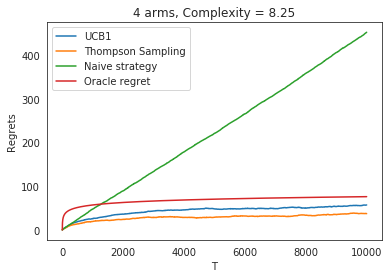

In [174]:
plt.plot(ucb1_regrets2)
plt.plot(ts_regrets2)
plt.plot(naive_regrets2)
plt.plot(oracles2)
plt.xlabel("T")
plt.ylabel("Regrets")
plt.title("4 arms, Complexity = {}".format(round(C2, 2)))
plt.legend(['UCB1', 'Thompson Sampling', 'Naive strategy', 'Oracle regret'])
plt.savefig('./report/1q1b.png')

## 1.2 Non-parametric bandits (bounded rewards)

In [187]:
# definition of bandit model
arm0 = ArmBernoulli(0.42, random_state=np.random.randint(1, 100000))
arm1 = ArmBeta(1, 2, random_state=np.random.randint(1, 100000))
arm2 =  ArmExp(4, random_state=np.random.randint(1, 100000))
arm3 = ArmBernoulli(0.52, random_state=np.random.randint(1, 100000))
arm4 = ArmBeta(4, 9, random_state=np.random.randint(1, 100000))
arm5 =  ArmExp(2.5, random_state=np.random.randint(1, 100000))
# Mixed MAB
MABM = [arm0, arm1, arm2, arm3, arm4, arm5]

#### Adapted TS

In [197]:
def one_ts(MAB, N_t, S_t):
    """Compute one iteration of the adapted Thompson Sampling strategy.
    
    Parameters:
    -----------
    
    MAB: list (arms)
        Multi arm bandit arms
    N_t: array, shape = [n_arms,]
        Number of draws of arms up to time t
    S_t: array, shape = [n_arms,]
        Sum of rewards gathered up to time t
    
    Returns:
    --------
    arm: integer
        id of arm to be pulled chosen by the algorithm
    reward: float
        The reward obtained
    N_t: array, shape = [n_arms,]
        Updated N_t
    S_t: array, shape = [n_arms,]
        Updated S_t
    """
    K = len(MAB)
    betas = np.array([np.random.beta(S_t[i] + 1, N_t[i] - S_t[i] + 1)  for i in range(K)])
    arm = np.argmax(betas)
    reward = float(MAB[arm].sample())
    reward = float(ArmBernoulli(reward, random_state=np.random.randint(1, 100000)).sample())
    N_t[arm] = N_t[arm] + 1
    S_t[arm] = S_t[arm] + reward
    return arm, reward, N_t, S_t

def adapted_ts(T, MAB):
    """Simulate a bandit game of length T with the adapted Thompson Sampling strategy.
    
    Parameters:
    -----------
    T: int
        Length of the simulation
    MAB: list (arms)
        Multi arm bandit arms
    
    Returns:
    --------
    rew: list(float)
        Sequence of the T rewards obtained
    draws: list(int)
        Sequence of the T arms drawn
    """
    rew, draws = [], []
    K = len(MAB)
    N_t = np.zeros(K)
    S_t = np.zeros(K)
    if T <= K:
        for i in range(T):
            N_t[i] = 1
            S_t[i] = int(MAB[i].sample())
            return list(S_t), list(range(T))
    else:
        for i in range(K):
            N_t[i] = 1
            S_t[i] = int(MAB[i].sample())
            
        rew, draws = list(S_t), list(range(K))
        for i in range(T - K):
            arm, reward, N_t, S_t= one_ts(MAB, N_t, S_t)
            rew.append(reward)
            draws.append(arm)
    return rew, draws

In [198]:
T = 10000
n = 100
algos = ["ucb1", "adapted_ts"]
MAB = MABM

In [201]:
regrets = expected_regret(MAB, T, n, algos)
ucb1_regrets = regrets[0, :]
ts_regrets = regrets[1, :]

100%|██████████| 100/100 [00:37<00:00,  2.65it/s]


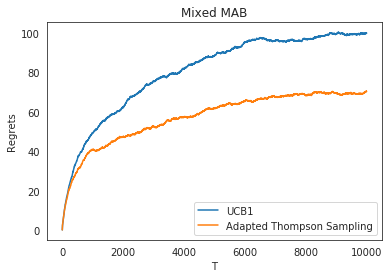

In [202]:
plt.plot(ucb1_regrets)
plt.plot(ts_regrets)
plt.xlabel("T")
plt.ylabel("Regrets")
plt.title("Mixed MAB")
plt.legend(['UCB1', 'Adapted Thompson Sampling'])
plt.savefig('./report/1q2.png')

# 2. Linear Bandit on Real Data

In [21]:
### LinUCB
def lin_ucb(model, T, lmbda, alpha, n_sim=100):
    """Implment the Linear UCB algorithm for the MAB model 'model'
    
    parameters:
    -----------
    model: LinearMABModel
        The MAB on which the algorith is applied
    T: int
        Time horizon
    lmbda: float
        Least squares regularisation parameter
    alpha: float
        Linear UCB parameter
    n_sim: int
        Number of simulations
    
    returns:
    --------
    regrets: array, shape=(T,)
        regrets cumulated over the rounds
    thetas: array, shape=(T)
        The value of norm of difference of thetas over the rounds
    """
    # Features
    features = model.features
    
    # Number of features
    d = model.n_features
    
    # Theta_*
    theta_s = model.real_theta
    
    # stores ||theta_s - theta||
    thetas = np.zeros((n_sim, T))
    
    # best reward
    b_reward = model.best_arm_reward()
    
    # stores cumulative regretes
    regrets = np.zeros((n_sim, T))

    for s in tqdm(range(n_sim), desc="Simulating LinUCB algorithm"):
        A = lmbda * np.eye(d)
        b = np.zeros(d)
        
        for i in range(T):
            # estimate theta
            theta = np.linalg.inv(A).dot(b)
            
            # select best arm
            alpha = np.sqrt(d * np.log((1 + i/lmbda)/sigma)) + np.sqrt(lmbda) * np.linalg.norm(theta)
            beta = alpha * np.sqrt(np.diag(features.dot(np.linalg.inv(A)).dot(features.T)))
            to_max = beta + features.dot(theta).ravel()
            arm = np.argmax(to_max)
            
            # save reward and theta
            reward = float(model.reward(arm))
            thetas[s, i] = np.linalg.norm(theta - theta_s)
            regrets[s, i] = b_reward - reward
            
            # update
            features_t = features[arm, :].reshape(-1, 1)
            A += features_t.dot(features_t.T)
            b += reward * features_t.flatten()

    # average simulations
    for i in range(1, T):
        regrets[:, i] = regrets[:, i] + regrets[:, i - 1]
    return np.mean(regrets, axis=0), np.mean(thetas, axis=0)

In [8]:
### Random
def random_s(model, T, lmbda, n_sim=100):
    """Implment the random policy for the linear MAB model 'model'
    
    parameters:
    -----------
    model: LinearMABModel
        The MAB on which the algorith is applied
    T: int
        Time horizon
    lmbda: float
        Least squares regularisation parameter
    n_sim: int
        Number of simulations
    
    returns:
    --------
    regrets: array, shape=(T,)
        regrets cumulated over the rounds
    thetas: array, shape=(T)
        The value of norm of difference of thetas over the rounds
    """
    # Features
    features = model.features
    
    # Number of features
    d = model.n_features
    
    # Number of action
    n_a = model.n_actions
    
    # Theta_*
    theta_s = model.real_theta
    
    # stores ||theta_s - theta||
    thetas = np.zeros((n_sim, T))
    
    # best reward
    b_reward = model.best_arm_reward()
    
    # stores cumulative regretes
    regrets = np.zeros((n_sim, T))

    for s in tqdm(range(n_sim), desc="Simulating Random algorithm"):
        
        A = lmbda * np.eye(d)
        b = np.zeros(d)
        for i in range(T):
            # estimate theta
            theta = np.linalg.inv(A).dot(b)
            
            # select  arm
            arm = np.random.randint(n_a)
            
            # save reward and theta
            reward = float(model.reward(arm))
            thetas[s, i] = np.linalg.norm(theta - theta_s)
            regrets[s, i] = b_reward - reward
            
            # update
            features_t = features[arm, :].reshape(-1, 1)
            A += features_t.dot(features_t.T)
            b += reward * features_t.flatten()

    # average simulations
    for i in range(1, T):
        regrets[:, i] = regrets[:, i] + regrets[:, i - 1]
    return np.mean(regrets, axis=0), np.mean(thetas, axis=0)

In [9]:
### Epsilon greedy
def eps_greedy(model, T, lmbda, eps, n_sim=100):
    """Implment the epsilon greedy algorithm for the MAB model 'model'
    
    parameters:
    -----------
    model: LinearMABModel
        The MAB on which the algorith is applied
    T: int
        Time horizon
    lmbda: float
        Least squares regularisation parameter
    eps: float
        The epsilon parameter
    n_sim: int
        Number of simulations
    
    returns:
    --------
    regrets: array, shape=(T,)
        regrets cumulated over the rounds
    thetas: array, shape=(T)
        The value of norm of difference of thetas over the rounds
    """
    # Features
    features = model.features
    
    # Number of features
    d = model.n_features
    
    # Number of action
    n_a = model.n_actions
    
    # Theta_*
    theta_s = model.real_theta
    
    # stores ||theta_s - theta||
    thetas = np.zeros((n_sim, T))
    
    # best reward
    b_reward = model.best_arm_reward()
    
    # stores cumulative regretes
    regrets = np.zeros((n_sim, T))

    for s in tqdm(range(n_sim), desc="Simulating LinUCB algorithm"):
        A = lmbda * np.eye(d)
        b = np.zeros(d)
        
        for i in range(T):
            # estimate theta
            theta = np.linalg.inv(A).dot(b)
            
            # select best arm
            if np.random.rand() < eps:
                arm = np.random.randint(n_a)
            else:
                arm = np.argmax(features.dot(theta))
            
            # save reward and theta
            reward = float(model.reward(arm))
            thetas[s, i] = np.linalg.norm(theta - theta_s)
            regrets[s, i] = b_reward - reward
            
            # update
            features_t = features[arm, :].reshape(-1, 1)
            A += features_t.dot(features_t.T)
            b += reward * features_t.flatten()

    # average simulations
    for i in range(1, T):
        regrets[:, i] = regrets[:, i] + regrets[:, i - 1]
    return np.mean(regrets, axis=0), np.mean(thetas, axis=0)

### Q3. Plots

In [3]:
model = ColdStartMovieLensModel(random_state=np.random.randint(0, 100000),noise=0.1)
T = 6000
nb_simu = 100

In [6]:
regrets_ucb, thetas_ucb = lin_ucb(model, T=T, lmbda=2, alpha=40, n_sim=nb_simu)

Simulating LinUCB algorithm: 100%|██████████| 100/100 [06:44<00:00,  3.50s/it]


In [14]:
regrets_rand, thetas_rand = random_s(model, T=T, lmbda=1, n_sim=nb_simu)

Simulating Random algorithm: 100%|██████████| 100/100 [02:13<00:00,  1.03s/it]


In [18]:
regrets_eps, thetas_eps = eps_greedy(model, T=T, lmbda=1, eps=0.4, n_sim=nb_simu)

Simulating LinUCB algorithm: 100%|██████████| 100/100 [01:59<00:00,  1.05s/it]


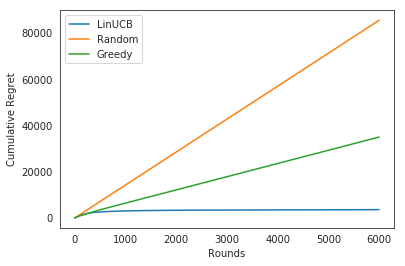

In [19]:
# Plot cumulative regret
plt.plot(regrets_ucb)
plt.plot(regrets_rand)
plt.plot(regrets_eps)
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regret")
plt.legend(["LinUCB", "Random", "Greedy"])
plt.savefig('./report/2q1b.png')

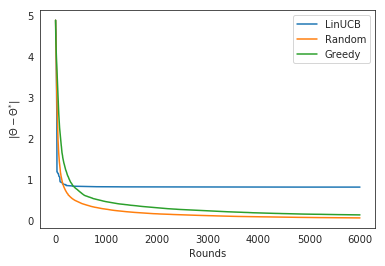

In [20]:
# Plot l2 theta
plt.plot(thetas_ucb)
plt.plot(thetas_rand)
plt.plot(thetas_eps)
plt.xlabel("Rounds")
plt.ylabel("$\|\Theta - \Theta^{*}\|$")
plt.legend(["LinUCB", "Random", "Greedy"])
plt.savefig('./report/2q2b.png')